In [ ]:
project_name='celebgan'

In [ ]:
pip install opendatasets --upgrade

# Downloading dataset

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/farzadnekouei/50k-celebrity-faces-image-dataset'

In [ ]:
od.download('https://www.kaggle.com/datasets/farzadnekouei/50k-celebrity-faces-image-dataset')

In [ ]:
import os
DATA_DIR= './50k-celebrity-faces-image-dataset/'
print(os.listdir(DATA_DIR))

In [ ]:
print(os.listdir(DATA_DIR+"/Celebrity_Faces_Dataset")[:10])

In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
image_size= 64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5) # means and standard deviations of 0.5 to normalize the data

In [ ]:
train_dataset= ImageFolder(DATA_DIR,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dataloader= DataLoader(train_dataset,batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0] #multiply with standard deviation and add mean

In [ ]:
def show_images(images,nmax=64):
    fig,ax= plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0)) #permute will rearrange index order
    #in pytorch, color channels in first dimension(i.e. [0])

def show_batch(dataloader,nmax=64):
    for images,_ in dataloader:
        show_images(images,nmax)
        break

In [ ]:
show_batch(train_dataloader)

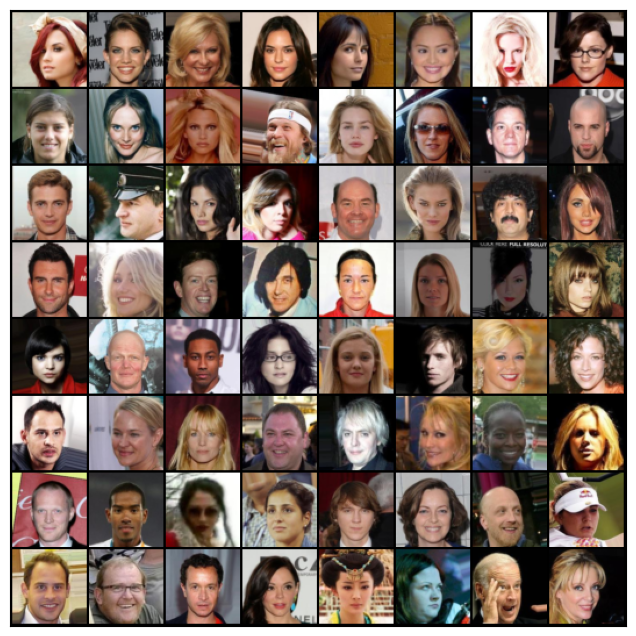

# Using GPU 

In [ ]:
def default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device): #tensor to device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dataloader,device):
        self.dataloader=dataloader
        self.device=device

    def __iter__(self): #yield iteratively batch of data after moving to device
        for x in self.dataloader:
            yield to_device(x,self.device)

    def __len__(self): #no of batches
        return len(self.dataloader)


In [ ]:
device=default_device()
device

In [ ]:
train_dataloader=DeviceDataLoader(train_dataloader,device)

# Discriminator Network

Differentiates between real or generated images

In [ ]:
import torch.nn as nn

discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

In [ ]:
discriminator=to_device(discriminator,device)

# Generator Network

Giving random inputs (128 random numbers batch) converted to image tensor of size 3x128x28
(change weights of generator so each time given random tensor outputs celeb face)

In [ ]:
#Transposed convolution(similar to de-convolution)
latent_size=256

In [ ]:
generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 128 x 128
        )

### Generating noise because not trained yet

In [ ]:
rn=torch.randn(batch_size,latent_size,1,1) #random numbers picked from gaussian distribution
print(rn.shape)
fake_images= generator(rn)
print(fake_images.shape)
show_images(fake_images)

* torch.Size([128, 256, 1, 1]) 
* torch.Size([128, 3, 64, 64])

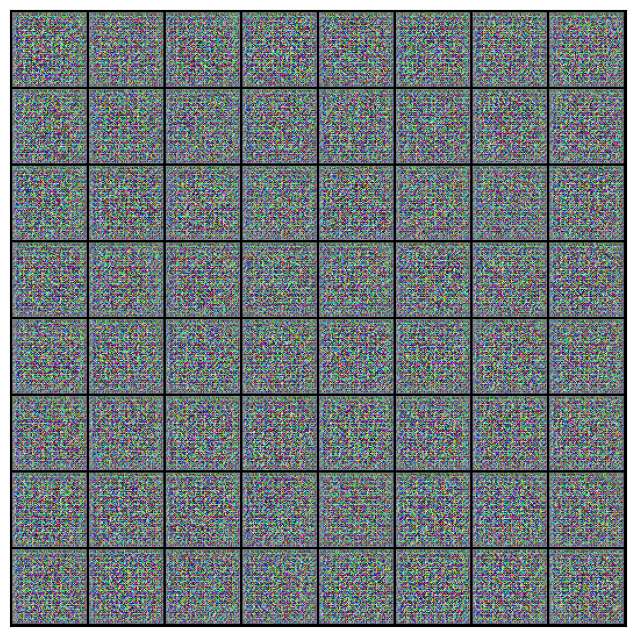

In [ ]:
generator=to_device(generator,device)

# Discriminator Training

In [ ]:
def train_discriminator(real_images, disc_optim):
    # Clear discriminator gradients
    disc_optim.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # total loss
    loss = real_loss + fake_loss
    loss.backward()
    disc_optim.step()
    return loss.item(), real_score, fake_score

* output 1 if image picked from real dataset and 
* output 0 if generated
#generator has to fool the discriminator which improves model

In [ ]:
import torch
import torch.nn.functional as F
def train_generator(gen_optim):
    # Clearing gradients
    gen_optim.zero_grad()
    #Generating the fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    #testing predictions
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    #update weights
    loss.backward()
    gen_optim.step()
    return loss.item()

After every single epoch, generate batch of images and save

In [ ]:
from torchvision.utils import save_image

In [ ]:
s_dir='generated'
os.makedirs(s_dir,exist_ok=True)

In [ ]:
def save_samples(index,latent_tensors,show=True):
    fake_images=generator(latent_tensors)
    fake_fname='generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(s_dir,fake_fname),nrow=8)
    print('Saving',fake_fname)
    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))



In [ ]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device) #capturinng features

In [ ]:
save_samples(0,fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998734..0.9998238].
Saving generated-images-0000.png

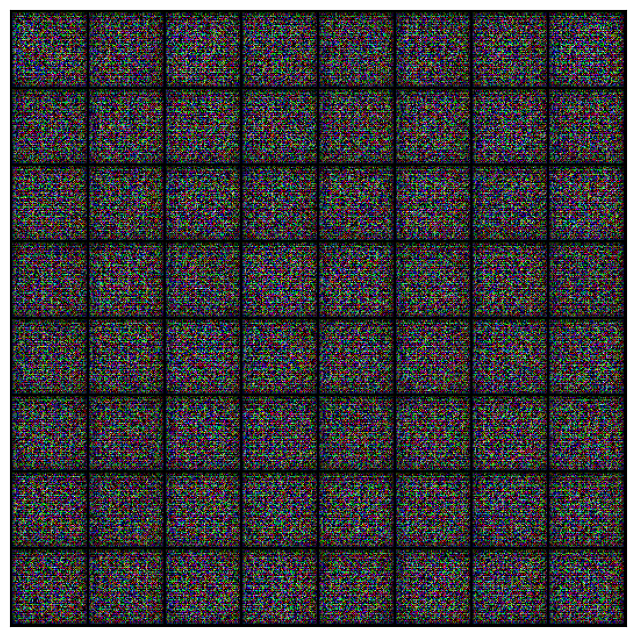

# Training Loop 

In [ ]:
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start=1):
    torch.cuda.empty_cache()

    # Losses
    gen_losses = []
    disc_losses = []
    real_scores = []
    fake_scores = []

    # Optimizers
    disc_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    gen_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in train_dataloader:
            # Train discriminator
            disc_loss, real_score, fake_score = train_discriminator(real_images, disc_optim)

            # Train generator
            gen_loss = train_generator(gen_optim)

            # Append losses and scores
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Print epoch statistics
        print(f"Epoch [{epoch + 1}/{epochs}], gen_loss: {gen_loss:.3f}, disc_loss: {disc_loss:.3f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
        # Save generated image
        save_samples(epoch + start, fixed_latent, show=False)

    return gen_losses, disc_losses, real_scores, fake_scores

In [ ]:
lr=0.00018
epochs=25

In [ ]:
history = fit(epochs,lr)

In [ ]:
gen_losses, disc_losses, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gen.pth')
torch.save(discriminator.state_dict(), 'Disc.pth')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

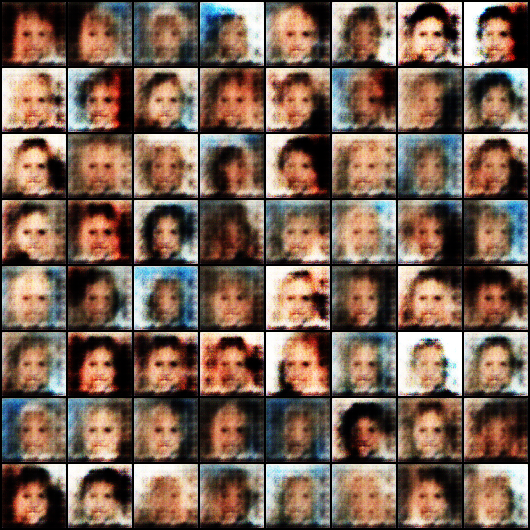

In [ ]:
Image('./generated/generated-images-0020.png')

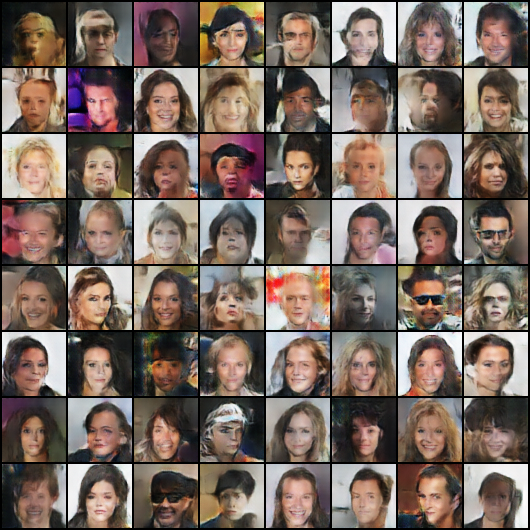

In [ ]:
Image('./generated/generated-images-0025.png')

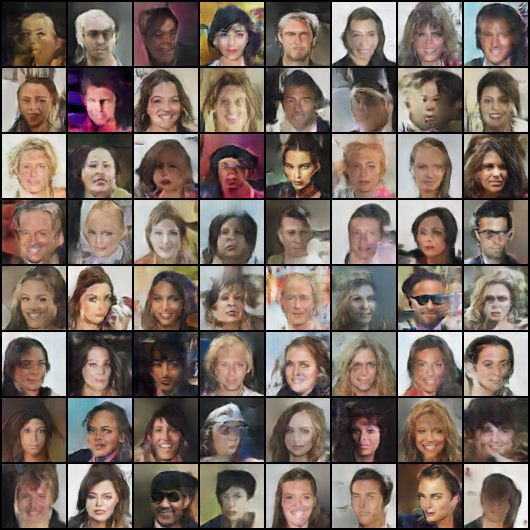

### Losses

In [ ]:
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

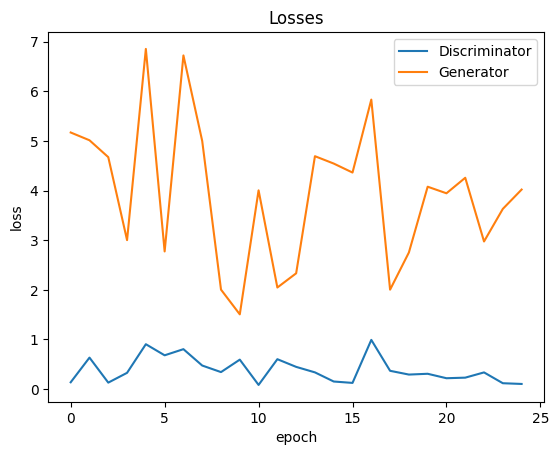

### Scores

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

#Text(0.5, 1.0, 'Scores')

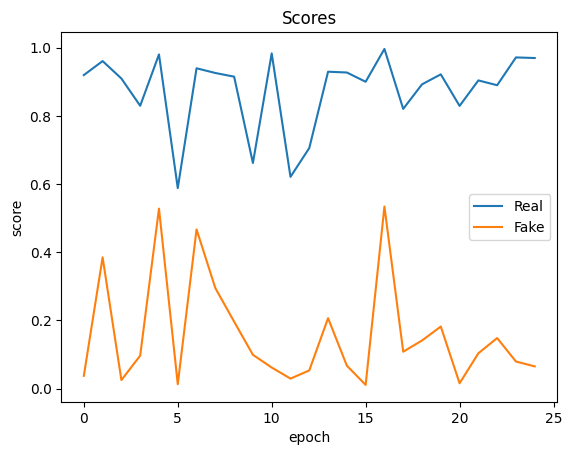